In [58]:
import gitlab
import pandas as pd
import pickle
import os
import numpy as np

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
def _connect_api():
    '''
    Returns:
        gitlab.Gitlab: API connection object
    
    '''
    if 'GITLAB_TOKEN' in os.environ:
        GITLAB_TOKEN = os.environ['GITLAB_TOKEN']
        gl = gitlab.Gitlab('http://gitlab.com',
                           private_token = GITLAB_TOKEN)
        gl.auth()
    else:
        raise Exception("Please set your Gitlab instance private token. https://gitlab.com/profile/personal_access_tokens")
    return gl


def download_issues():
    '''
    Download Gitlab issues via https://docs.gitlab.com/ee/api/issues.html
    '''
    gl = _connect_api()
    # Project ids for GitLab Community Edition and GitLab Enterprise Edition
    projects = [gl.projects.get(13083)] + [gl.projects.get(278964)]
    issues = []
    for project in projects:
        issue_list = project.issues.list(all = True)
        issues.append(issue_list)
    pickle.dump(iss, open(issue_file_path, 'wb'))

In [65]:
issue_file_path = os.path.join("..", "data", "gitlab-issues.pkl")

In [66]:
if os.path.isfile(issue_file_path):
    issues = pickle.load( open( issue_file_path, "rb" ))
else:
    download_issues()
    issues = pickle.load( open( issue_file_path, "rb" ))

In [67]:
def get_issues(issues, project):
    '''
    Create Pandas df from the issue data
    Unfortunetaly 
    '''
    df_issues = pd.DataFrame(columns=['id',
                                      'desc',
                                      'title',
                                      'tags',
                                      'author',
                                      'project',
                                      'created_at'])
    for issue in issues:
        df_issues = df_issues.append({'id': issue.id,
                       'desc' : issue.attributes['description'],
                       'title' : issue.attributes['title'],
                       'tags' : issue.attributes['labels'],
                       'author' : issue.attributes['author']['id'],
                       'project' : project,
                       'created_at' : issue.attributes['created_at']}, ignore_index=True)
    return df_issues

df_issues = pd.concat([get_issues(issues[0], 'GitLab Community Edition'),
                          get_issues(issues[1], 'GitLab Enterprise Edition')],
                      ignore_index=True)
df_issues.head()

id                                               desc  \
0  13308948  ### Summary\n\nIf repository mirroring fails (...   
1  13308533  ### Problem to solve\nIt would be nice to be a...   
2  13307635  Hi, I'm doing setup gitlab-ce with docker.\n\n...   
3  13307532  After I backup and restore the gitlab to anoth...   
4  13307385  <!---\nPlease read this!\n\nBefore opening a n...   

                                               title tags   author  \
0  Text and Background color hides error message ...   []  2075452   
1                                      Timed Tickets   []  2106895   
2  Set my domain to Project path at new creation ...   []  2674299   
3  Registry doesn't work properly after backup an...   []   315344   
4  Filename has been changed if upload via web in...   []  2674174   

                    project                created_at  
0  GitLab Community Edition  2018-08-08T06:56:56.268Z  
1  GitLab Community Edition  2018-08-08T06:25:43.101Z  
2  GitLab Community Edition  2018-08-08T04:40:04.743Z  
3  GitLab Community Edition  2018-08-08T04:25:18.021Z  
4  GitLab Community Edition  2018-08-08T04:07:15.305Z

In [21]:
df_issues.groupby(['project'])['id'].nunique()

project
GitLab Community Edition     39693
GitLab Enterprise Edition     6952
Name: id, dtype: int64

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7]

In [70]:
# Covert ts to date
df_issues["dt_created"] = pd.to_datetime(df_issues.created_at).dt.normalize()

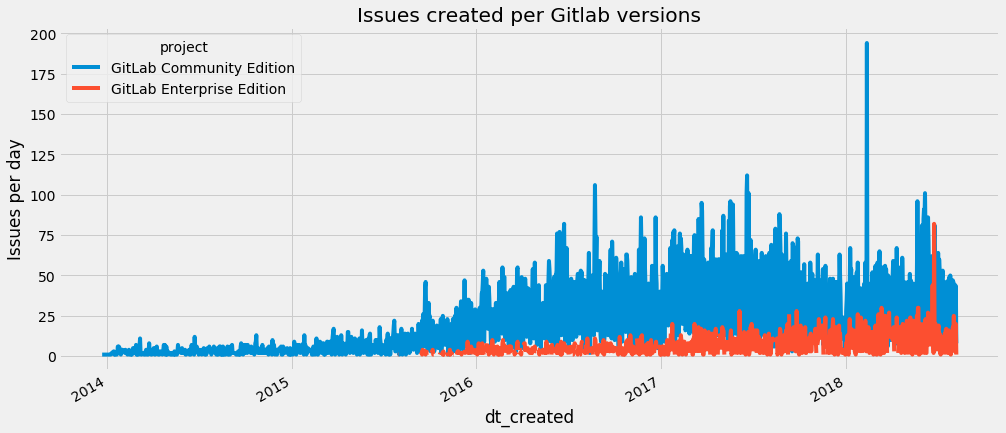

In [43]:
df_issues.groupby(['dt_created', 'project'])['id']\
    .nunique()\
    .reset_index(name = 'count')\
    .pivot('dt_created', 'project', 'count')\
    .plot();
plt.ylabel('Issues per day');
plt.title('Issues created per Gitlab versions');

Interesting... 

gitlab ee has less issues, it's okey may lot of issues are confidental so I can't see those.

Why ce issues are decreasing?

What happend in June?

May worth to check how these correlate to release dates (22nd of each month)

How number of ce issues are correlated to total projects created on gitlab.com?


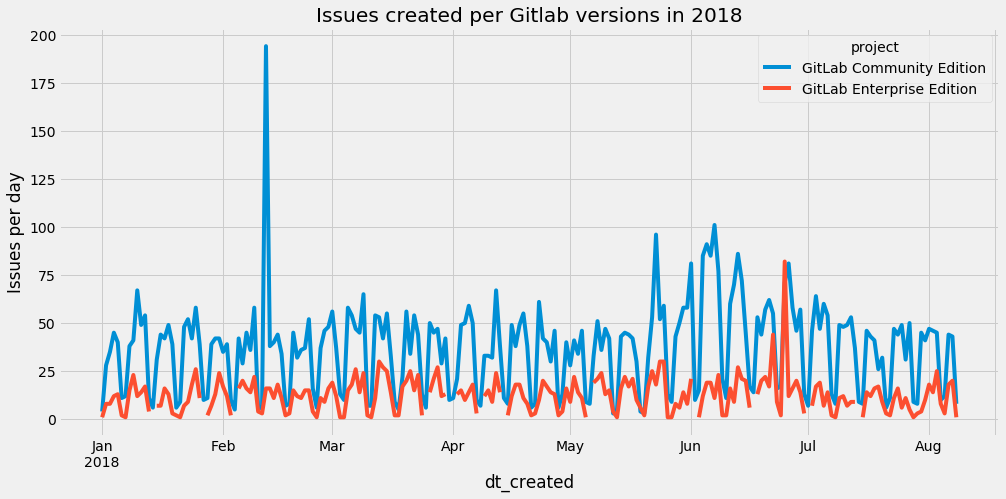

In [44]:
df_issues[df_issues.dt_created >= '2018-01-01'].groupby(['dt_created', 'project'])['id']\
    .nunique()\
    .reset_index(name = 'count')\
    .pivot('dt_created', 'project', 'count')\
    .plot();
plt.ylabel('Issues per day');
plt.title('Issues created per Gitlab versions in 2018');

In [51]:
from fbprophet import Prophet
import logging

logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [40]:
df_for_fc_ce = df_issues[(df_issues.dt_created >= '2018-01-01') & (df_issues.project == 'GitLab Community Edition')]\
    .groupby(['dt_created'])['id']\
    .nunique()\
    .reset_index(name = 'issues')
#Prophet is expecting ds and y cols
df_for_fc_ce.columns = ['ds', 'y']

df_for_fc_ee = df_issues[(df_issues.dt_created >= '2018-01-01') & (df_issues.project == 'GitLab Enterprise Edition')]\
    .groupby(['dt_created'])['id']\
    .nunique()\
    .reset_index(name = 'issues')
#Prophet is expecting ds and y cols
df_for_fc_ee.columns = ['ds', 'y']

Let's check components of the time series based on issues created on daily basis


As expected on weekends ppl rest and don't create issues


See the details below

In [54]:
model = Prophet()
model.fit(df_for_fc_ce);
forecast = model.predict(model.make_future_dataframe(periods=30));

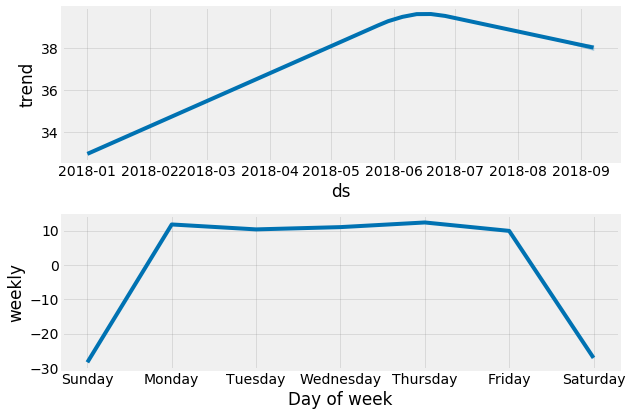

In [55]:
model.plot_components(forecast);

In [56]:
model = Prophet();
model.fit(df_for_fc_ee);
forecast = model.predict(model.make_future_dataframe(periods=30));

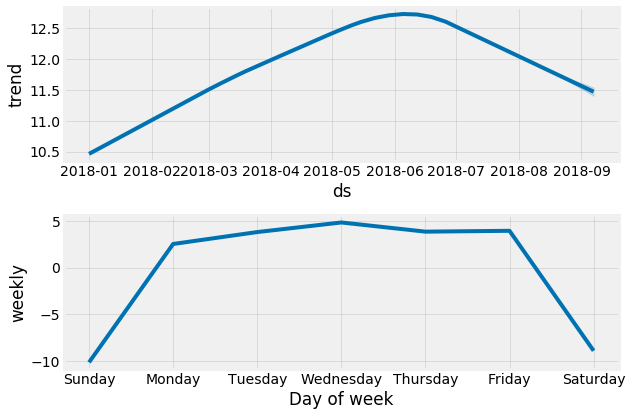

In [57]:
model.plot_components(forecast);

My first idea was to somehow get the author email/org but turned out it's available for admins only. So I query for gitlab-com group members and joining it with issue authors this will show how much issue created by gitlab members and others.

In [55]:
def get_gitlab_members():
    '''
    Returns:
        list of gitlab group members
    '''
    gl = _connect_api()
    gitlab_com = gl.groups.get('gitlab-com')
    gitlab_com_members = gitlab_com.members.list(all = True)
    members = []
    for member in gitlab_com_members:
        members.append(member.id)
    return members

In [65]:
l_gitlab_members = get_gitlab_members()
df_issues['author_is_member'] = np.where(df_issues.author.isin(l_gitlab_members), 'Gitlab member', 'Community member')

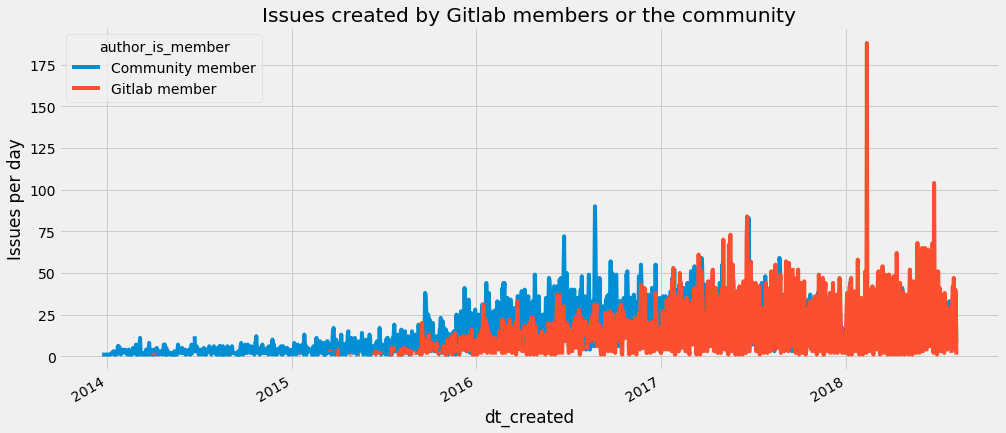

In [66]:
df_issues.groupby(['dt_created', 'author_is_member'])['id']\
    .nunique()\
    .reset_index(name = 'count')\
    .pivot('dt_created', 'author_is_member', 'count')\
    .plot();
plt.ylabel('Issues per day');
plt.title('Issues created by Gitlab members or the community');

Something weird with the results ^^

I expected that gitlab projects members contributed a lot to issues at the beginning but this is not the case.

Let's check top issue authors

In [95]:
def most_active_author(ts):
    return df_issues[df_issues.dt_created < pd.Timestamp(ts)]\
                .groupby('author')\
                .size()\
                .reset_index(name = 'issues_created_by_user')\
                .sort_values('issues_created_by_user', ascending = False)\
                .head()

In [78]:
gl = _connect_api()

In [96]:
for user in most_active_author('2015-01-01')['author']:
    user_details = gl.users.get(user)
    print(user_details.name, user_details.web_url)

CSchulz https://gitlab.com/cschulz
David Anderson https://gitlab.com/dvander
Peter Reid https://gitlab.com/ReidWeb
sashk https://gitlab.com/sashk
Eric Range https://gitlab.com/ericrange


In [97]:
for user in most_active_author('2018-08-13')['author']:
    user_details = gl.users.get(user)
    print(user_details.name, user_details.web_url)

Stan Hu https://gitlab.com/stanhu
Mark Pundsack https://gitlab.com/markpundsack
Victor Wu https://gitlab.com/victorwu
Yorick Peterse https://gitlab.com/yorickpeterse
Rémy Coutable - ⛰ OOO back on 2018-08-20 ⛰ https://gitlab.com/rymai
